In [1]:
import matplotlib.pyplot as plt
import neurolib.utils.functions as func
import seaborn as sns
import scipy.stats as ss
from scipy.stats import ranksums
from petTOAD_setup import *

plt.rcParams["image.cmap"] = "plasma"

Getting the layout...
Done with the layout...
The following patients were discarded for having ROIs with all zeros: []
petTOAD Setup done!


In [2]:
import my_functions as my_func

In [3]:
# Define functions
def calculate_avg_fc(group):
    n_subj = len(group)
    N = group[next(iter(group))].shape[0]
    fc_group = np.zeros([N, N])
    for _, ts in group.items():
        fc_group += func.fc(ts)
    fc_avg = fc_group / n_subj
    # Change correlation with itself to 0, otherwise arctanh(1) = inf
    np.fill_diagonal(fc_avg, 0)
    # Fisher transform
    fc_avg_z = np.arctanh(fc_avg)

    return fc_avg_z

def plot_avg_fc(name_1, fc1, name_2, fc2):
    plt.figure()
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(fc1)
    axs[0].set_title(f"{name_1}")
    axs[1].imshow(fc2)
    axs[1].set_title(f"{name_2}")
    plt.show()


def process_group_avg_fc(fc_avg_1, fc_avg_2):
    # Calculate pairwise differences between conditions
    pairwise_diff = fc_avg_1 - fc_avg_2

    # Calculate global FC as the mean absolute (so to also consider negative correlations) value of the FC matrix across all pairs of areas
    N = fc_avg_1.shape[0]
    glob_fc_1 = (np.sum(np.abs(fc_avg_1), axis=1) - 1) / N
    glob_fc_2 = (np.sum(np.abs(fc_avg_2), axis=1) - 1) / N

    # Calculate node strength as the sum over columns of the sFC matrix
    node_strength_1 = np.sum(fc_avg_1, axis=0)
    node_strength_2 = np.sum(fc_avg_2, axis=0)

    # Calculate node diversity as the standard deviation over columns of the sFC matrix
    node_diversity_1 = np.std(fc_avg_1, axis=0)
    node_diversity_2 = np.std(fc_avg_2, axis=0)

    # Test differences in pairwise, node, and global metrics across conditions using a Wilcoxon ranksum test
    pairwise_pvalue = ranksums(pairwise_diff.flatten(), np.zeros(pairwise_diff.size))[1]
    node_strength_pvalue = ranksums(node_strength_1, node_strength_2)[1]
    node_diversity_pvalue = ranksums(node_diversity_1, node_diversity_2)[1]
    global_fc_pvalue = ranksums(glob_fc_1.flatten(), glob_fc_2.flatten())[1]

    # Apply Bonferroni correction for multiple comparisons
    n_pairs = N * (N - 1) / 2
    pairwise_alpha = 0.05 / n_pairs
    node_alpha = 0.05 / fc_avg_1.shape[0]
    global_alpha = 0.05 / fc_avg_1.shape[0]

    if pairwise_pvalue < pairwise_alpha:
        print(
            f"Pairwise differences are significant, p-value: {round(pairwise_pvalue, 5)} < {pairwise_alpha}"
        )
    else:
        print(
            f"Pairwise differences are not significant, p-value: {round(pairwise_pvalue, 5)} > {pairwise_alpha}"
        )

    if node_strength_pvalue < node_alpha:
        print(
            f"Node strength differences are significant, p-value: {round(node_strength_pvalue, 5)} < {node_alpha}"
        )
    else:
        print(
            f"Node strength differences are not significant, p-value: {round(node_strength_pvalue, 5)} > {node_alpha} "
        )

    if node_diversity_pvalue < node_alpha:
        print(
            f"Node diversity differences are significant. p-value: {round(node_diversity_pvalue, 5)} < {node_alpha}"
        )
    else:
        print(
            f"Node diversity differences are not significant, p-value: {round(node_diversity_pvalue, 5)} > {node_alpha}"
        )

    if global_fc_pvalue < global_alpha:
        print(
            f"Global FC differences are significant, p-value: {round(global_fc_pvalue, 5)} < {global_alpha}"
        )
    else:
        print(
            f"Global FC differences are not significant, p-value: {round(global_fc_pvalue, 5)} > {global_alpha}"
        )

    return [glob_fc_1, node_strength_1, node_diversity_1], [
        glob_fc_2,
        node_strength_2,
        node_diversity_2,
    ]


def regr_eq(reg_plot, axs_n):
    #calculate slope and intercept of regression equation
    slope, intercept, r, p, sterr = ss.linregress(x=reg_plot.get_lines()[0].get_xdata(),
                                                        y=reg_plot.get_lines()[0].get_ydata())
    ann_x = reg_plot.get_lines()[0].get_xdata().min() + 0.2
    axs[axs_n].annotate(f"y = {round(slope, 3)}x + {round(intercept, 2)}",[ann_x, 0.7])                                       



<Figure size 640x480 with 0 Axes>

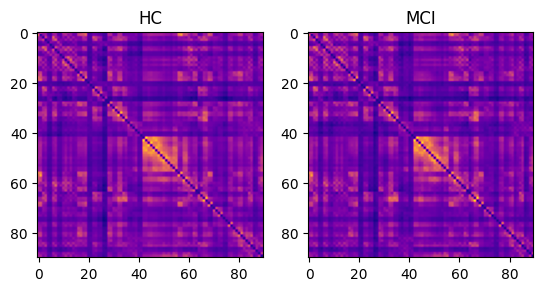

Pairwise differences are significant, p-value: 0.0 < 1.2484394506866417e-05
Node strength differences are not significant, p-value: 0.00856 > 0.0005555555555555556 
Node diversity differences are not significant, p-value: 0.04677 > 0.0005555555555555556
Global FC differences are not significant, p-value: 0.00842 > 0.0005555555555555556


In [4]:
# Comparisons between HC and MCI total
HC_dict = {k: v for k, v in all_fMRI_clean.items() if k in HC}
MCI_dict = {k: v for k, v in all_fMRI_clean.items() if k in MCI}
# Calculate averages amongst groups
fc_avg_hc = calculate_avg_fc(HC_dict)
fc_avg_mci = calculate_avg_fc(MCI_dict)
# Plot average fcs
plot_avg_fc("HC", fc_avg_hc, "MCI", fc_avg_mci)
# Perform group comparison
list_results_hc, list_results_mci = process_group_avg_fc(fc_avg_hc, fc_avg_mci)

<Figure size 640x480 with 0 Axes>

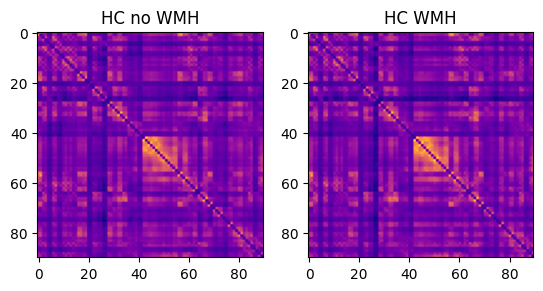

Pairwise differences are significant, p-value: 0.0 < 1.2484394506866417e-05
Node strength differences are not significant, p-value: 0.1422 > 0.0005555555555555556 
Node diversity differences are not significant, p-value: 0.17507 > 0.0005555555555555556
Global FC differences are not significant, p-value: 0.14142 > 0.0005555555555555556


In [5]:
# Comparisons between HC with/without WMH
HC_no_WMH_dict = {k: v for k, v in all_fMRI_clean.items() if k in HC_no_WMH}
HC_WMH_dict = {k: v for k, v in all_fMRI_clean.items() if k in HC_WMH}
# Calculate averages amongst groups
fc_avg_hc_no_wmh = calculate_avg_fc(HC_no_WMH_dict)
fc_avg_hc_wmh = calculate_avg_fc(HC_WMH_dict)
# Plot average fcs
plot_avg_fc("HC no WMH", fc_avg_hc_no_wmh, "HC WMH", fc_avg_hc_wmh)
# Perform group comparison
list_results_hc_no_wmh, list_results_hc_wmh = process_group_avg_fc(fc_avg_hc_no_wmh, fc_avg_hc_wmh)

<Figure size 640x480 with 0 Axes>

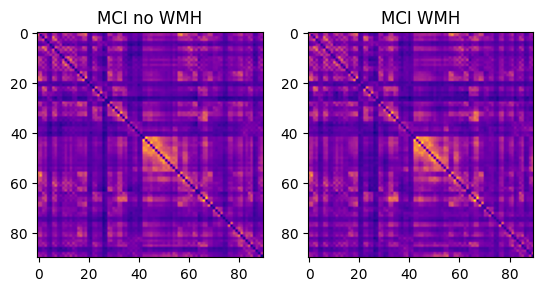

Pairwise differences are significant, p-value: 0.0 < 1.2484394506866417e-05
Node strength differences are significant, p-value: 0.0 < 0.0005555555555555556
Node diversity differences are not significant, p-value: 0.39549 > 0.0005555555555555556
Global FC differences are significant, p-value: 0.0 < 0.0005555555555555556


In [6]:
# Comparisons between MCI with/without WMH
MCI_no_WMH_dict = {k: v for k, v in all_fMRI_clean.items() if k in MCI_no_WMH}
MCI_WMH_dict = {k: v for k, v in all_fMRI_clean.items() if k in MCI_WMH}
# Calculate averages amongst groups
fc_avg_mci_no_wmh = calculate_avg_fc(MCI_no_WMH_dict)
fc_avg_mci_wmh = calculate_avg_fc(MCI_WMH_dict)
# Plot average fcs
plot_avg_fc("MCI no WMH", fc_avg_mci_no_wmh, "MCI WMH", fc_avg_mci_wmh)
# Perform group comparison
list_results_mci_no_wmh, list_results_mci_wmh = process_group_avg_fc(fc_avg_mci_no_wmh, fc_avg_mci_wmh)

In [7]:
_, _ = process_group_avg_fc(fc_avg_hc_no_wmh, fc_avg_mci_wmh)

Pairwise differences are significant, p-value: 0.0 < 1.2484394506866417e-05
Node strength differences are significant, p-value: 0.0 < 0.0005555555555555556
Node diversity differences are not significant, p-value: 0.00475 > 0.0005555555555555556
Global FC differences are significant, p-value: 0.0 < 0.0005555555555555556


In [8]:
wmh_dict = get_wmh_load_homogeneous(subjs)

In [9]:
df_fc_wmh = pd.DataFrame()
list_glob_fc = []
list_subj = []
list_wmh = []
list_classification = []
for subj, ts in all_fMRI_clean.items():
    if subj in HC_no_WMH:
        list_classification.append("HC_no_WMH")
    elif subj in HC_WMH:
        list_classification.append("HC_WMH")
    elif subj in MCI_no_WMH:
        list_classification.append("MCI_no_WMH")
    elif subj in MCI_WMH:
        list_classification.append("MCI_WMH")
    list_subj.append(subj)
    list_wmh.append(wmh_dict[subj])
    fc = func.fc(ts)
    N = fc.shape[0]
    glob_fc = ((np.sum(np.abs(fc), axis=1) - 1) / N).mean()
    list_glob_fc.append(glob_fc)

In [10]:
df_fc_wmh["PTID"] = list_subj
df_fc_wmh["glob_fc"] = list_glob_fc
df_fc_wmh["wmh"] = list_wmh
df_fc_wmh["wmh_log"] = np.where(df_fc_wmh["wmh"] == 0, 0, np.log(df_fc_wmh["wmh"]))
df_fc_wmh["classification"] = list_classification

c:\Users\leoner\AppData\Local\miniconda3\envs\neurolib\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


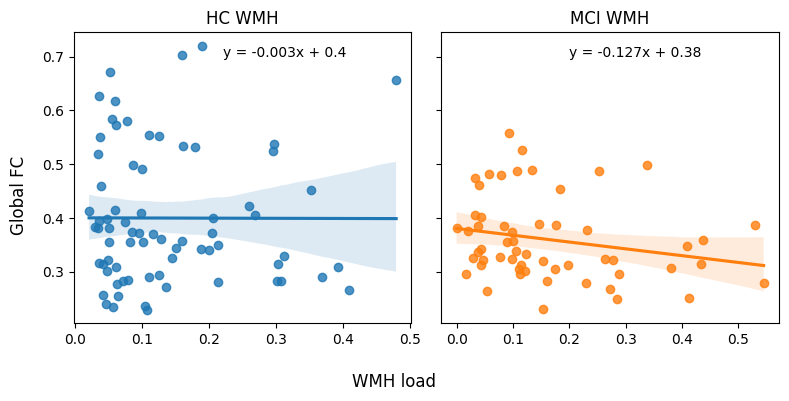

In [11]:
# In HC and MCI no WMH the distribution of WMH is too narrow (0.0-0.06 so that measurement error might be greater than any real effect) so we don't plot them
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4), sharey = True)
r0 = sns.regplot(ax = axs[0], data = df_fc_wmh[(df_fc_wmh["classification"] == "HC_WMH") & (df_fc_wmh["wmh"] < 0.8)], x = "wmh", y = "glob_fc", color = "tab:blue")
regr_eq(r0, 0)                
axs[0].set_title("HC WMH")
axs[0].set(xlabel=None, ylabel = None)
r1 = sns.regplot(ax = axs[1], data = df_fc_wmh[(df_fc_wmh["classification"] == "MCI_WMH") & (df_fc_wmh["wmh"] < 0.8)], x = "wmh", y = "glob_fc", color = "tab:orange")
regr_eq(r1, 1)                
axs[1].set_title("MCI WMH")
axs[1].set(xlabel=None, ylabel = None)
fig.supylabel("Global FC")
fig.supxlabel("WMH load")
fig.tight_layout()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HC_no_WMH_0.0 vs. HC_no_WMH_1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:9.813e-01 U_stat=2.310e+02
HC_no_WMH_1.0 vs. HC_no_WMH_2.0: Mann-Whitney-Wilcoxon test two-sided, P_val:5.000e-01 U_stat=3.000e+00
MCI_no_WMH_0.0 vs. MCI_no_WMH_1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:7.710e-02 U_stat=1.280e+02
MCI_no_WMH_1.0 vs. MCI_no_WMH_2.0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.300e+01
MCI_WMH_1.0 vs. MCI_WMH_2.0: Mann-Whitney-Wilcoxon test two-sided, P_val:6.667e-01 U_stat=6.000e+00
HC_WMH_0.0 vs. HC_WMH_1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:4.495e-01 U_stat=1.830e+02
HC_WMH_1.0 vs. HC_WMH_2.0: Mann-Whitney-Wilcoxon test two-sided, P_val:4.393e-01 U_stat=2.600e+01
MCI_WMH_0.0 vs. MCI_WMH_1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:8.044e-01 U_stat=5.600e+01
HC_

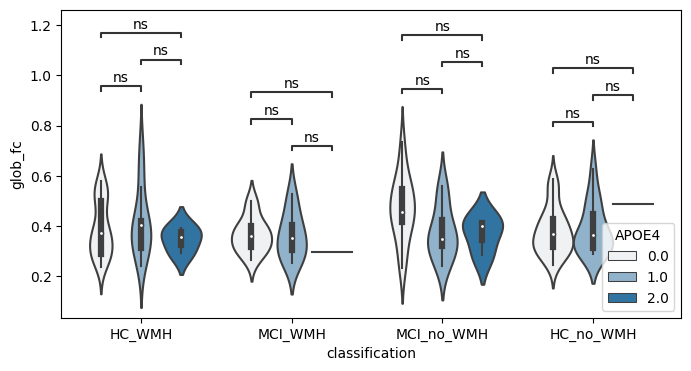

In [12]:
# Try some stuff with APOE4
from statannotations.Annotator import Annotator

adnimerge = pd.read_csv(UTL_DIR / "ADNIMERGE.csv")
adnimerge["PTID"] = "ADNI" + adnimerge["PTID"].str.replace("_","")
df_fc_wmh_merged = pd.merge(df_fc_wmh, adnimerge[["APOE4", "PTID"]], on = "PTID").drop_duplicates().dropna()
df_fc_wmh_merged["APOE4"] = df_fc_wmh_merged["APOE4"].astype(str)

def plot_hc_mci_comparison(axs):
    """
    This function is for plotting the comparison between the model results achieved in HC and MCI with the same model"""
    pairs = [
        (("HC_no_WMH", "0.0"), ("HC_no_WMH", "1.0")),
        (("HC_no_WMH", "0.0"), ("HC_no_WMH", "2.0")),
        (("HC_no_WMH", "1.0"), ("HC_no_WMH", "2.0")),
        (("HC_WMH", "0.0"), ("HC_WMH", "1.0")),
        (("HC_WMH", "0.0"), ("HC_WMH", "2.0")),
        (("HC_WMH", "1.0"), ("HC_WMH", "2.0")),
        (("MCI_no_WMH", "0.0"), ("MCI_no_WMH", "1.0")),
        (("MCI_no_WMH", "0.0"), ("MCI_no_WMH", "2.0")),
        (("MCI_no_WMH", "1.0"), ("MCI_no_WMH", "2.0")),
        (("MCI_WMH", "0.0"), ("MCI_WMH", "1.0")),
        (("MCI_WMH", "0.0"), ("MCI_WMH", "2.0")),
        (("MCI_WMH", "1.0"), ("MCI_WMH", "2.0"))]

    # This is a dictionary of arguments that are passed into the function inside map_dataframe
    kwargs = {
        'plot_params': { # this takes what normally goes into sns.barplot etc.
            'x': 'classification',
            'y': 'glob_fc',
            'hue': 'APOE4',
            'hue_order': ["0.0", "1.0", "2.0"]
        },
        'annotation_func': 'apply_test', 
        'configuration': {'test': 'Mann-Whitney'}, # this takes what normally goes into ant.configure
        'plot': 'violinplot',
        # If you want to add the figure into a subplot...
        'ax': axs
    }

    ant = Annotator(None, pairs)
    # We create a FacetGrid and pass the dataframe that we want to use to later apply our functions (plotting the comparisons between groups)
    g1 = sns.FacetGrid(df_fc_wmh_merged, aspect = 1.5, height = 4)
    # map_dataframe accepts a function, which it then applies to the dataframe that is previously passed in the FacetGrid. It also accepts kwargs which 
    # are passed inside the function
    g1.map_dataframe(ant.plot_and_annotate_facets, **kwargs)
    plt.close()

fig, axs = plt.subplots(nrows= 1, ncols = 1, figsize = (8, 4))
plot_hc_mci_comparison(axs)
